In [1]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc

In [2]:
fuel = openmc.Material(name='uo2')
fuel.add_element('U',1.0, enrichment=19.75)
fuel.add_element('O',2.0)
fuel.set_density=10.5
fuel.temperature = 1200

clad_in = openmc.Material(name='graphite')
clad_in.add_element('C',1.0)
clad_in.temperature = 1200

clad_out = openmc.Material(name='SiC')
clad_out.add_element('C',1.0)
clad_out.add_element('Si',1.0)
clad_out.temperature = 900

coolant = openmc.Material(name='LiOH+NaOH')
coolant.add_element('Li',1.0, enrichment=99.995, enrichment_target='Li7',enrichment_type='ao')
coolant.add_element('H',1.0)
coolant.add_element('O',1.0)
coolant.add_element('Na',1.0)
coolant.set_density('g/cm3', 1.670)
coolant.temperature = 900 

moderator = openmc.Material(name='graphite')
moderator.add_element('C',1.0)
moderator.temperature = 900

e_moderator = openmc.Material(name='graphite')
e_moderator.add_element('C',1.0)
e_moderator.temperature = 900 

materials = openmc.Materials([fuel,clad_in,clad_out,coolant,moderator])
materials.export_to_xml()

/home/m240600/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/material.py:740: UserWarning: A uranium enrichment of 19.75 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


In [3]:
r_fuel   = 0.35
r_clad_1 = 0.5
r_clad_2 = 0.6

r_pt_in  = 7.5 #inner radius of the graphite pressure tube
r_pt_out = 8.5 #outer radius of the graphite pressure tube

lattice_pitch = 18

H=163.345 #core height in cm
D=H #core diameter in cm

ring_radii = np.array([0.0, 2.1, 4.2, 6.2])

surf_fuel = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_fuel)

surf_clad_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_1)
surf_clad_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_clad_2)

surf_pt_1 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_in)
surf_pt_2 = openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r_pt_out)

In [4]:
radial_surf = [openmc.model.RightCircularCylinder((0,0,-81.6725),163.345,r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

coolant_cells = []
for i in range(ring_radii.size):
    if i == 0:
        coolant_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        coolant_region = +radial_surf[i-1] & -surf_pt_1
    else:
        coolant_region = +radial_surf[i-1] & -radial_surf[i]

    coolant_cells.append(openmc.Cell(fill=coolant, region=coolant_region))

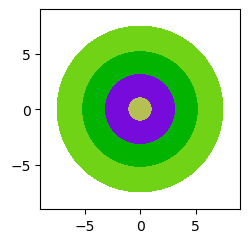

In [5]:
plot_args = {'width':(lattice_pitch,lattice_pitch)}
bundle_universe = openmc.Universe(cells=coolant_cells)
bundle_universe.plot(**plot_args)

In [6]:
fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)

clad_cell_1 = openmc.Cell(fill=clad_in, region=+surf_fuel & -surf_clad_1)
clad_cell_2 = openmc.Cell(fill=clad_out, region=+surf_clad_1 & -surf_clad_2)

pin_universe = openmc.Universe(cells=(fuel_cell,clad_cell_1,clad_cell_2))

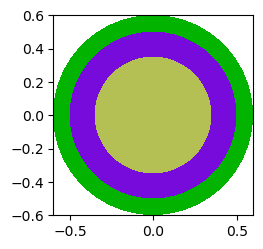

In [7]:
pin_universe.plot(**{'width':(2*r_clad_2,2*r_clad_2)})

In [8]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        theta = (a + j/n*360)*pi/180.
        x = r*cos(theta)
        y = r*sin(theta)

        pin_boundary = openmc.ZCylinder(x0=x,y0=y,r=r_clad_2)
        coolant_cells[i].region &= +pin_boundary

        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

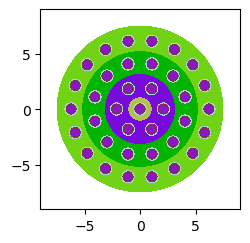

In [9]:
bundle_universe.plot(**plot_args)

In [10]:
lattice_boundary = openmc.model.RectangularParallelepiped(-lattice_pitch/2,lattice_pitch/2,-lattice_pitch/2,lattice_pitch/2,-81.6725,81.6725)

pt=openmc.Cell(fill=clad_in, region= +surf_pt_1 & -surf_pt_2)
bundle_universe.add_cell(pt)
moderator_cell=openmc.Cell(fill=moderator, region=-lattice_boundary & +surf_pt_2)
bundle_universe.add_cell(moderator_cell)

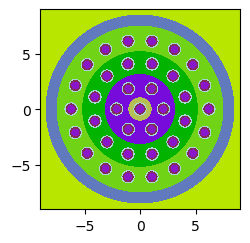

In [11]:
bdu=bundle_universe
bdu.plot(**plot_args)

In [12]:
external_moderator=openmc.Cell(fill=e_moderator, region=-lattice_boundary)
emu = openmc.Universe(cells=[external_moderator])

In [19]:
core_body = openmc.model.RightCircularCylinder((0,0,-H/2),H,D/2, boundary_type='vacuum')

N_assy = 9
CL = openmc.RectLattice(); #Core Lattice
CL.center = (0.,0.)
CL.dimension = [N_assy,N_assy];
CL.lower_left = [-N_assy/2.*lattice_pitch,-N_assy/2.*lattice_pitch]
CL.pitch= [lattice_pitch,lattice_pitch]
CL.universes = [
    [emu,emu,emu,emu,bdu,emu,emu,emu,emu],
    [emu,emu,bdu,bdu,bdu,bdu,bdu,emu,emu],
    [emu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,emu],
    [emu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,emu],
    [bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,bdu],
    [emu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,emu],
    [emu,bdu,bdu,bdu,bdu,bdu,bdu,bdu,emu],
    [emu,emu,bdu,bdu,bdu,bdu,bdu,emu,emu],    
    [emu,emu,emu,emu,bdu,emu,emu,emu,emu]
]
CL.outer=emu

C = openmc.Universe();
core_cell = openmc.Cell();
core_cell.region = -core_body;
core_cell.fill = CL;
C.add_cell(core_cell);

In [20]:
geometry = openmc.Geometry(C)
geometry.export_to_xml()

materials=openmc.Materials(geometry.get_all_materials().values())
materials.export_to_xml()

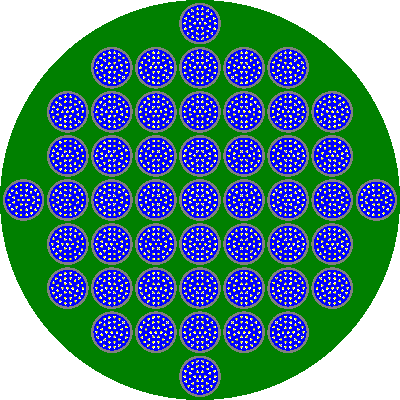

In [21]:
plot = openmc.Plot.from_geometry(geometry)
#plot.basis='xz'
#plot.origin=(0,0,-81.6725)
plot.color_by = 'material'
plot.colors = {
    fuel: 'yellow',
    clad_in: 'grey',
    clad_out: 'white',
    coolant: 'blue',
    moderator: 'green',
    e_moderator: 'green',
}
plot.to_ipython_image()

In [22]:
settings = openmc.Settings()
settings.particles = 5000
settings.batches = 50
settings.inactive = 10
settings.source = openmc.Source(space=openmc.stats.Point())
settings.export_to_xml()

In [23]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]

In [24]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################